#Lab-5: Regularization for Deep Neural Networks

###Regularization:

Regularization is a technique used in machine learning and neural networks to prevent overfitting and improve the generalization performance of models. Overfitting occurs when a model learns to fit the training data too closely, capturing noise and irrelevant patterns, which leads to poor performance on unseen data.The following illustration, called the generalization curve, shows that the training loss keeps decreasing by increasing the number of training iterations:

![](https://i.imgur.com/j6P8EPq.png)

Regularization methods introduce additional constraints or penalties on the model's parameters during training, encouraging simpler models that are less likely to overfit. These constraints can take various forms:
* L1 regularization (Lasso)
* L2 regularization (Ridge)
* Dropout
* Early stopping
* Data augmentation

Here's why regularization is needed:

* Preventing Overfitting: The primary purpose of regularization is to prevent overfitting, where a model memorizes the training data instead of learning generalizable patterns. By imposing constraints on the model's parameters, regularization helps to smooth the learning process and reduce the complexity of the learned function, leading to better generalization to unseen data.

* Improving Generalization: Regularization encourages the model to learn simpler and smoother decision boundaries, which are less sensitive to noise and variations in the training data. This improves the model's ability to generalize well to new, unseen examples, leading to better performance on real-world data.

# Downloading the Dependencies and Loading data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

torch.manual_seed(42)

# Visualize Dataset Samples

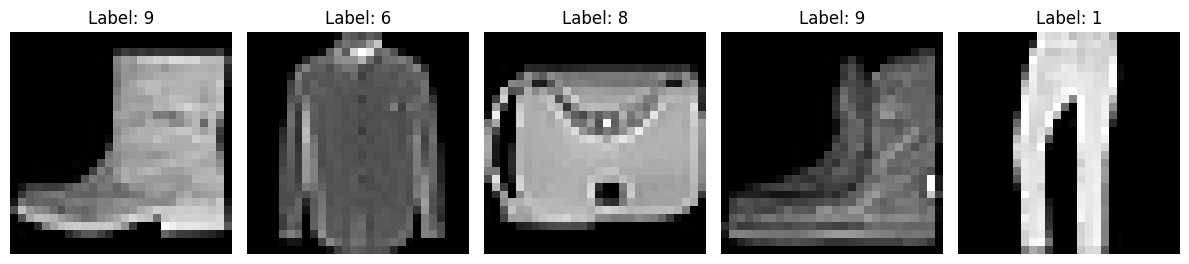

In [ ]:
# Visualize some samples from dataset
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Set the number of images to visualize
num_images = 5

# Create a figure with subplots to display multiple images
fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

# Randomly select indices to display images
indices = torch.randint(0, len(dataset), (num_images,))

for i, idx in enumerate(indices):
    # Get the image and label
    image, label = dataset[idx]

    # Convert the image tensor to a numpy array for visualization
    image = image.squeeze(0)  # Remove the channel dimension (1x28x28 -> 28x28)

    # Plot the image
    axes[i].imshow(image, cmap='gray')

    # Set the title to the label
    axes[i].set_title(f"Label: {label}")

    # Remove axes ticks
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


# Define Dataloaders

In [ ]:
def load_data():
    # Define transformations for normalization
    transform = transforms.Compose([transforms.ToTensor()])

    # Load FashionMNIST dataset
    dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

    # Split dataset (70% train, 15% validation, 15% test)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

# Define Fully Connected Neural Network


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the model (enhanced to induce more overfitting)
class OverfittingNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=4096, hidden_size2=2048, hidden_size3=1024, hidden_size4=512 ,hidden_size5=256, output_size=10):
        super(OverfittingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size5, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        return x




In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Test Accuracy: {acc:.4f}, Test F1 Score: {f1:.4f}")
    return acc, f1

def plot_losses(train_losses, val_losses, title):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Load dataset
train_loader, val_loader, test_loader = load_data()


In [ ]:
# Train baseline model
overfitting_model = OverfittingNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(overfitting_model.parameters(), lr=0.01)

# Train and Evaluate Performance


Training Unregularized Model...
Epoch [1/50], Train Loss: 2.2872, Val Loss: 2.2555
Epoch [2/50], Train Loss: 1.7996, Val Loss: 1.2591
Epoch [3/50], Train Loss: 0.9417, Val Loss: 0.8950
Epoch [4/50], Train Loss: 0.7933, Val Loss: 0.7676
Epoch [5/50], Train Loss: 0.7068, Val Loss: 0.8403
Epoch [6/50], Train Loss: 0.6478, Val Loss: 0.7732
Epoch [7/50], Train Loss: 0.5945, Val Loss: 0.6779
Epoch [8/50], Train Loss: 0.5482, Val Loss: 0.5759
Epoch [9/50], Train Loss: 0.5070, Val Loss: 0.5399
Epoch [10/50], Train Loss: 0.4779, Val Loss: 0.5652
Epoch [11/50], Train Loss: 0.4500, Val Loss: 0.4886
Epoch [12/50], Train Loss: 0.4309, Val Loss: 0.4560
Epoch [13/50], Train Loss: 0.4146, Val Loss: 0.4815
Epoch [14/50], Train Loss: 0.3975, Val Loss: 0.4557
Epoch [15/50], Train Loss: 0.3810, Val Loss: 0.5967
Epoch [16/50], Train Loss: 0.3688, Val Loss: 0.4138
Epoch [17/50], Train Loss: 0.3538, Val Loss: 0.4041
Epoch [18/50], Train Loss: 0.3420, Val Loss: 0.4539
Epoch [19/50], Train Loss: 0.3340, Val Lo

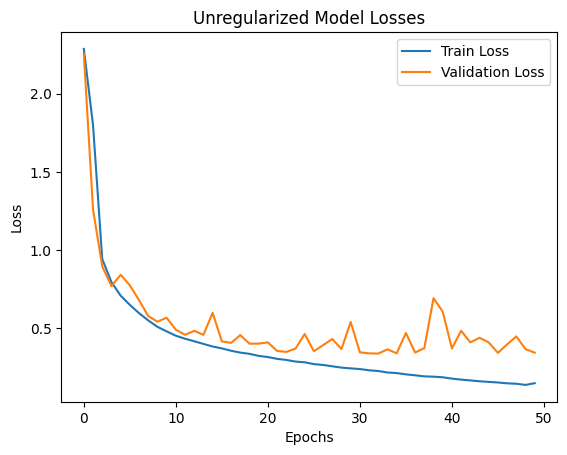

Test Accuracy: 0.8856, Test F1 Score: 0.8846


(0.8856, 0.8846385822707827)

In [ ]:
print("Training Unregularized Model...")
overfitting_train_losses, overfitting_val_losses = train_model(overfitting_model, train_loader, val_loader, optimizer, criterion)
plot_losses(overfitting_train_losses, overfitting_val_losses, "Unregularized Model Losses")
evaluate_model(overfitting_model, test_loader)

L1 and L2 regularization are two common techniques used to prevent overfitting in machine learning models, including neural networks. They work by adding penalty terms to the loss function during training, which encourage the model's weights to remain small or sparse.

### **L1 Regularization (Lasso Regression):**
L1 regularization, also known as Lasso regression, adds a penalty term to the loss function that is proportional to the absolute value of the model's weights:
$L_{\text{L1}} = \lambda \sum_{i=1}^{n} |w_i|$

$L_{\text{L1}}$​ is the L1 regularization term.
$λ$ is the regularization parameter, controlling the strength of regularization.
$w_i$​ are the weights of the model.

**Properties of L1 Regularization:**

**1. Sparsity**: L1 regularization encourages sparsity in the model's weights, leading some weights to become exactly zero. This property makes L1 regularization useful for feature selection and creating more interpretable models.

**2. Robustness to Outliers**: L1 regularization is less sensitive to outliers in the data compared to L2 regularization, as it can shrink coefficients to zero.

### **L2 regularization (Ridge Regression)**
L2 regularization, also known as Ridge regression, adds a penalty term to the loss function that is proportional to the square of the model's weights:
$L_{\text{L2}} = \lambda \sum_{i=1}^{n} w_i^{2}$

$L_{\text{L2}}$​ is the L2 regularization term.
$λ$ is the regularization parameter, controlling the strength of regularization.
$w_i$​ are the weights of the model.

**Properties of L2 Regularization:**

**1. Shrinkage**: L2 regularization encourages small weights across all features, but it rarely leads to exactly zero weights. It tends to shrink the weights toward zero without making them zero, which makes it less suitable for feature selection compared to L1 regularization.

**2. Robustness to Collinearity**:  L2 regularization is more robust to collinearity (high correlation between features) compared to L1 regularization.


5.Implement L2 regularization from scratch and train the neural network with L2 regularization. Show the corresponding loss plots for this model side by side with the unregularized model. Also compare the accuracy and F1 performance of the two models.   

# Implement L2 Regularization From Scratch

In [ ]:
# Define the model with L2 Regularization
class RegularizedCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=4096, hidden_size2=2048, hidden_size3=1024, hidden_size4=512, hidden_size5=256, output_size=10, l2_lambda=0.0035):
        super(RegularizedCNN, self).__init__()
        self.l2_lambda = l2_lambda
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size5, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        return x

    def l2_regularization(self):
        l2_reg = torch.tensor(0., device=self.fc1.weight.device)
        for name, param in self.named_parameters():
            if 'bias' not in name:
                 l2_reg += torch.norm(param, p=2) ** 2
        return 0.5 * self.l2_lambda * l2_reg

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses, val_losses = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            loss += model.l2_regularization()
            loss.backward()
            optimizer.step()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='macro')
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    return train_losses, val_losses

In [ ]:
# Train baseline model
model = RegularizedCNN(l2_lambda=0.01).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train and Evaluate Model with L2 Regularization


Training Model with L2 Regularization...
Epoch [1/50], Train Loss: 2.2930, Val Loss: 2.2793, Acc: 0.2941, F1: 0.1477
Epoch [2/50], Train Loss: 2.1339, Val Loss: 1.5949, Acc: 0.3912, F1: 0.2998
Epoch [3/50], Train Loss: 1.1987, Val Loss: 1.1403, Acc: 0.5001, F1: 0.4281
Epoch [4/50], Train Loss: 0.9532, Val Loss: 0.9188, Acc: 0.6617, F1: 0.6313
Epoch [5/50], Train Loss: 0.8357, Val Loss: 0.8611, Acc: 0.6646, F1: 0.6337
Epoch [6/50], Train Loss: 0.7705, Val Loss: 0.7621, Acc: 0.7357, F1: 0.7397
Epoch [7/50], Train Loss: 0.7279, Val Loss: 0.7692, Acc: 0.7146, F1: 0.6857
Epoch [8/50], Train Loss: 0.6937, Val Loss: 0.7588, Acc: 0.7178, F1: 0.6959
Epoch [9/50], Train Loss: 0.6620, Val Loss: 0.7252, Acc: 0.7411, F1: 0.7236
Epoch [10/50], Train Loss: 0.6387, Val Loss: 0.6619, Acc: 0.7643, F1: 0.7583
Epoch [11/50], Train Loss: 0.6196, Val Loss: 0.6911, Acc: 0.7466, F1: 0.7341
Epoch [12/50], Train Loss: 0.6004, Val Loss: 0.5890, Acc: 0.7978, F1: 0.7982
Epoch [13/50], Train Loss: 0.5805, Val Loss:

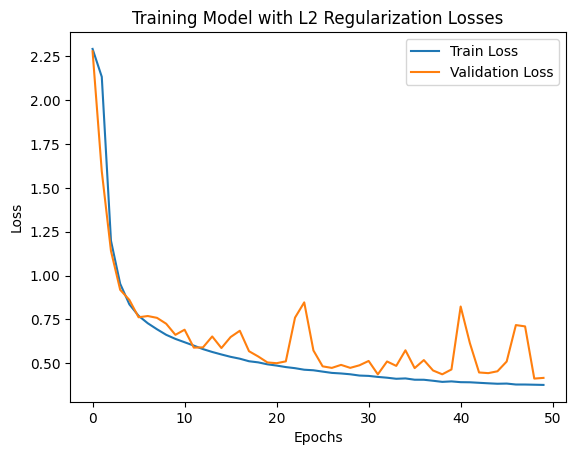

In [ ]:
print("Training Model with L2 Regularization...")
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion)
evaluate_model(model, test_loader)
plot_losses(train_losses, val_losses, "Training Model with L2 Regularization Losses")

# Implement Dropout Regularization From Scratch

In [ ]:
# Define the model with Dropout implemented from scratch
class RegularizedNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=4096, hidden_size2=2048, hidden_size3=1024, hidden_size4=512, hidden_size5=256, output_size=10, dropout_prob=0.4):
        super(RegularizedNN, self).__init__()
        self.dropout_prob = dropout_prob
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size)

    def dropout(self, x):
        if self.training:
            mask = (torch.rand(x.shape, device=x.device) > self.dropout_prob).float()
            return x * mask / (1 - self.dropout_prob)
        return x

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.fc5(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses, val_losses = [], []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            # loss += model.l2_lambda * sum(torch.norm(param, p=2) ** 2 for name, param in model.named_parameters() if 'bias' not in name)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='macro')
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    return train_losses, val_losses


In [ ]:
model = RegularizedNN(dropout_prob=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Training Model with Dropout...")
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion)
evaluate_model(model, test_loader)

Training Model with Dropout...
Epoch [1/50], Train Loss: 2.2986, Val Loss: 2.2877, Acc: 0.1854, F1: 0.0865
Epoch [2/50], Train Loss: 2.2288, Val Loss: 1.9586, Acc: 0.2373, F1: 0.1473
Epoch [3/50], Train Loss: 1.3782, Val Loss: 0.9956, Acc: 0.5707, F1: 0.4983
Epoch [4/50], Train Loss: 0.9919, Val Loss: 0.9299, Acc: 0.6328, F1: 0.6069
Epoch [5/50], Train Loss: 0.8778, Val Loss: 0.7971, Acc: 0.6631, F1: 0.6115
Epoch [6/50], Train Loss: 0.8010, Val Loss: 0.7089, Acc: 0.7261, F1: 0.7034
Epoch [7/50], Train Loss: 0.7415, Val Loss: 0.6988, Acc: 0.7268, F1: 0.6907
Epoch [8/50], Train Loss: 0.6854, Val Loss: 0.6135, Acc: 0.7812, F1: 0.7832
Epoch [9/50], Train Loss: 0.6441, Val Loss: 0.5747, Acc: 0.7831, F1: 0.7552
Epoch [10/50], Train Loss: 0.6092, Val Loss: 0.5454, Acc: 0.7964, F1: 0.7733
Epoch [11/50], Train Loss: 0.5789, Val Loss: 0.5026, Acc: 0.8118, F1: 0.7879
Epoch [12/50], Train Loss: 0.5574, Val Loss: 0.5412, Acc: 0.7924, F1: 0.7633
Epoch [13/50], Train Loss: 0.5347, Val Loss: 0.5308, A

(0.8469, 0.8377423623651934)

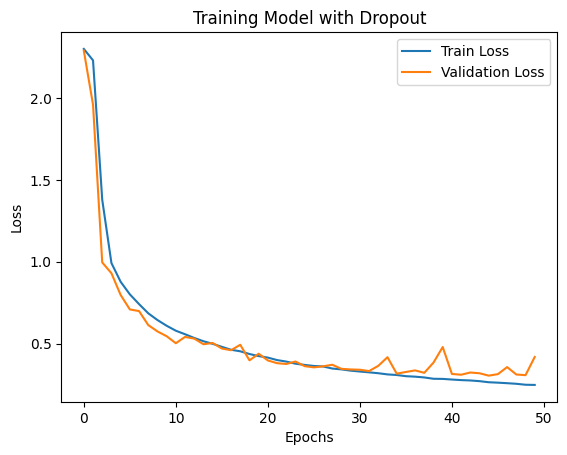

In [ ]:
plot_losses(train_losses, val_losses, "Training Model with Dropout")

# Use PyTorch to Apply Data Augmentation and Regularization (L2 + Dropout)

**Data augmentation**

Data augmentation is a technique used to artificially increase the size and diversity of a training dataset by applying various transformations to the original data samples. The goal of data augmentation is to improve the generalization performance of machine learning models by exposing them to a wider range of variations in the input data. This helps the model learn invariant features and become more robust to different conditions and variations present in real-world data.

Now, let's explain each transformation in the provided transform_augment sequence:

* **RandomHorizontalFlip**: This transformation randomly flips the input images horizontally with a certain probability (usually 0.5). It is commonly used in computer vision tasks to augment the dataset with horizontally flipped versions of the images. This helps the model to learn features that are invariant to left-right orientation.

* **ColorJitter**: This transformation randomly adjusts the brightness, contrast, saturation, and hue of the input images. By changing the color distribution of the images, ColorJitter helps the model to become more invariant to changes in lighting conditions and color variations in the input data.

* **RandomRotation**: This transformation randomly rotates the input images by a specified angle. Random rotation introduces variations in object orientation, which helps the model learn features that are invariant to rotation and improve its generalization performance.

Training regularized model...
Epoch [1/50], Train Loss: 2.2898, Val Loss: 2.2428, Acc: 0.2230, F1: 0.1421
Epoch [2/50], Train Loss: 1.7189, Val Loss: 1.1788, Acc: 0.4890, F1: 0.4371
Epoch [3/50], Train Loss: 1.1095, Val Loss: 0.9364, Acc: 0.6414, F1: 0.5948
Epoch [4/50], Train Loss: 0.9510, Val Loss: 0.8849, Acc: 0.6500, F1: 0.6150
Epoch [5/50], Train Loss: 0.8644, Val Loss: 0.7696, Acc: 0.6878, F1: 0.6542
Epoch [6/50], Train Loss: 0.7921, Val Loss: 0.7021, Acc: 0.7452, F1: 0.7339
Epoch [7/50], Train Loss: 0.7191, Val Loss: 0.6597, Acc: 0.7540, F1: 0.7462
Epoch [8/50], Train Loss: 0.6604, Val Loss: 0.6296, Acc: 0.7570, F1: 0.7352
Epoch [9/50], Train Loss: 0.6212, Val Loss: 0.5585, Acc: 0.7947, F1: 0.7883
Epoch [10/50], Train Loss: 0.5932, Val Loss: 0.5272, Acc: 0.8005, F1: 0.7871
Epoch [11/50], Train Loss: 0.5667, Val Loss: 0.5108, Acc: 0.8149, F1: 0.8084
Epoch [12/50], Train Loss: 0.5448, Val Loss: 0.4977, Acc: 0.8199, F1: 0.8156
Epoch [13/50], Train Loss: 0.5278, Val Loss: 0.4893, Ac

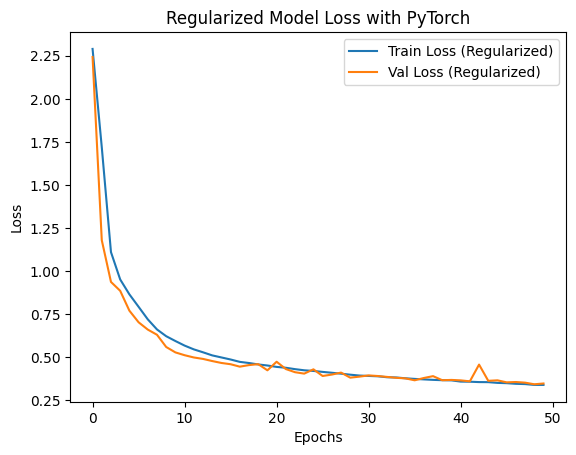

Regularized Model - Accuracy: 0.8763, F1 Score: 0.8760


In [ ]:
# Define transformations with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform_train, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform_test, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the neural network model
class RegularizedNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=4096, hidden_size2=2048, hidden_size3=1024, hidden_size4=512, hidden_size5=256, output_size=10, dropout_prob=0.4):
        super(RegularizedNN, self).__init__()
        self.dropout_prob = dropout_prob
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.fc5(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc6(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses, val_losses = [], []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss, y_true, y_pred = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='macro')
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}")

    return train_losses, val_losses, val_accuracy, val_f1

# Instantiate models and optimizer
regularized_model = RegularizedNN(dropout_prob=0.3).to(device)
criterion = nn.CrossEntropyLoss()


regularized_optimizer = optim.SGD(regularized_model.parameters(), lr=0.01, weight_decay=0.0001)


print("Training regularized model...")
reg_train_losses, reg_val_losses, reg_acc, reg_f1 = train_model(regularized_model, train_loader, test_loader, regularized_optimizer, criterion)


plt.plot(reg_train_losses, label='Train Loss (Regularized)')
plt.plot(reg_val_losses, label='Val Loss (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Regularized Model Loss with PyTorch')
plt.show()


print(f"Regularized Model - Accuracy: {reg_acc:.4f}, F1 Score: {reg_f1:.4f}")


#Assignment-5 [20 Marks]

###Task-1: Data Preparation [1.5 Marks]
(i) Load the [superconductivity dataset](https://archive.ics.uci.edu/dataset/464/superconductivty+data) (train.csv) from UCI

(ii) Split the dataset into training(70%), validation(15%) and test sets(15%)

(iii) Perform feature scaling uisng StandardScaler()

###Task-2: PyTorch Dataset and DataLoader [2 Marks]
(i) Convert the training, validation and test splits into PyTorch tensors

(ii) Create PyTorch DataLoader objects for training and validation sets using a batch size of 64

###Task-3: Neural Network Architecture Definition [3 Marks]
Design a fully connected feed-forward neural network for predicting the superconducting critical temperature.

The network architecture must be defined as follows:

(i) Input layer size equal to the number of input features (81)

(ii) Three hidden layers with 256, 128 and 64 neurons, respectively

(iii) ReLU activation after each hidden layer

(iv) Output layer with one neuron and no activation function

###Task-4: Batch Normalization from Scratch [3 Marks]
(i) Implement a custom Batch Normalization layer without using torch.nn.BatchNorm1d

(ii) The implementation must include:

- Learnable scale (γ) and shift (β) parameters

- Running mean and running variance for inference

(iii) Insert Batch Normalization:

- After each hidden linear layer

- Before the activation function


###Task-5: Model Training [5 Marks]
(i) Use Mean Squared Error (MSE) as the loss function

(ii) Train the model for 100 epochs with Adam Optimizer using the following batch sizes:

{4, 8, 16, 32, 64, 128, 256}

(iii) For each batch size and each epoch, record:

- Training loss

- Validation loss

(iv) For each batch size, plot:

- Training loss vs epochs

- Validation loss vs epochs

###Task-6: Test Set Evaluation [1 Mark]

For each model trained in Task-5, perform inference on the test set.

(i) Compute the following metrics:

- Mean Squared Error (MSE)

- R² score

(ii) Tabulate the MSE and R² scores for all batch sizes

###Task-7: Batch Size vs Performance Analysis [1 Mark]

(i) Plot the R² score as a function of batch size

(ii) Explain your observations from this plot

(iii) Which batch size achieves the lowest R^2 score and why?

###Task-8: Prediction Scatter Plot [0.5 Marks]

Show the scatter plot of the predictions of the models trained with the batch size that achieves the best R^2 score on the test set vs. ground truths

###Task-9: BN using PyTorch [3 Marks]
(i) Implement BN using PyTorch

(ii) Train the model with the batch size that achieved the best R^2 score

(iii) Report the R^2 score obtained with PyTorch’s implementation of batch normalization

(iv) Show the scatter plot